In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(
    root='/datasets', train=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                           shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(
    root='/datasets', train=False, transform=transform)

test_loader = torch.utils.data.DataLoader(testset, batch_size=64,
                                          shuffle=False, num_workers=4)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog',
           'horse', 'ship', 'truck')

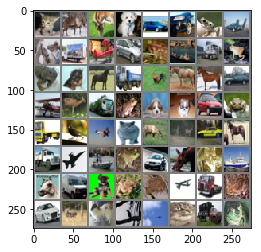

  cat  deer  deer   dog


In [3]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
               

dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
plt.show()
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        
        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*4*4, 1024)
        self.fc2 = nn.Linear(1024, 1024)
        self.fc3 = nn.Linear(1024, 128)
        self.fc4 = nn.Linear(128, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  # 32 x 32 x 32
        x = F.relu(self.conv2(x))  # 32 x 32 x 32
        x = self.pool(x)  # 16 x 16 x 32
        
        x = F.relu(self.conv3(x))  # 16 x 16 x 64
        x = F.relu(self.conv4(x))  # 16 x 16 x 64
        x = self.pool(x)  # 8 x 8 x 64
        
        x = F.relu(self.conv5(x))  # 8 x 8 x 128
        x = F.relu(self.conv6(x))  # 8 x 8 x 128
        x = self.pool(x)  # 4 x 4 x 128
        
        x = x.view(-1, 128*4*4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x
    
net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9)

In [ ]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 1):
        inputs, labels = data
        
        inputs, labels = Variable(inputs), Variable(labels)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        if i % 2000 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i,
                                            running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
plt.show()
print('GroundTruth:',
      ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)
print('Predicted:',
      ' '.join('%5s' % classes[predicted[j][0]] for j in range(4)))

In [ ]:
correct = 0
total = 0
for data in test_loader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' %(
      100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data in test_loader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1
        
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))

In [10]:
net = Net()
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3)

for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 1):
        inputs, labels = data
        
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data[0]
        if i % 200 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch+1, i,
                                            running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.196
[1,   400] loss: 0.163
[1,   600] loss: 0.144
[2,   200] loss: 0.118
[2,   400] loss: 0.113
[2,   600] loss: 0.103
[3,   200] loss: 0.087
[3,   400] loss: 0.085
[3,   600] loss: 0.079
[4,   200] loss: 0.068
[4,   400] loss: 0.068
[4,   600] loss: 0.067
[5,   200] loss: 0.057
[5,   400] loss: 0.056
[5,   600] loss: 0.057
[6,   200] loss: 0.046
[6,   400] loss: 0.047
[6,   600] loss: 0.048
[7,   200] loss: 0.037
[7,   400] loss: 0.039
[7,   600] loss: 0.040
[8,   200] loss: 0.028
[8,   400] loss: 0.032
[8,   600] loss: 0.032
[9,   200] loss: 0.023
[9,   400] loss: 0.024
[9,   600] loss: 0.026
[10,   200] loss: 0.019
[10,   400] loss: 0.020
[10,   600] loss: 0.021
Finished Training


In [11]:
correct = 0
total = 0
for data in test_loader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted.cpu() == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' %(
      100 * correct / total))

Accuracy of the network on the 10000 test images: 77 %


In [12]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

for data in test_loader:
    images, labels = data
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted.cpu() == labels).squeeze()
    for i in range(labels.size(0)):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1
        
for i in range(10):
    print('Accuracy of %5s: %2d %%' % (
          classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane: 79 %
Accuracy of   car: 88 %
Accuracy of  bird: 62 %
Accuracy of   cat: 59 %
Accuracy of  deer: 73 %
Accuracy of   dog: 72 %
Accuracy of  frog: 83 %
Accuracy of horse: 80 %
Accuracy of  ship: 83 %
Accuracy of truck: 91 %
